<a href="https://colab.research.google.com/github/jcjang1/kaggle_dataset_maker/blob/main/converting_img2img.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 1.1 MB/s 


In [ ]:
!gdown 1uvZSxjMGdIHYLwSMwOccJN-MdFX_ejIQ

Downloading...
From: https://drive.google.com/uc?id=1uvZSxjMGdIHYLwSMwOccJN-MdFX_ejIQ
To: /content/conv_origin_512+768_dataset.zip
100% 2.74G/2.74G [00:22<00:00, 120MB/s]


In [ ]:
!unzip /content/conv_origin_512+768_dataset.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: conv_origin_512+768_dataset/images/512_26174_0000.png  
  inflating: conv_origin_512+768_dataset/images/768_30394_0000.png  
  inflating: conv_origin_512+768_dataset/images/768_28052_0001.png  
  inflating: conv_origin_512+768_dataset/images/512_12483_0008.png  
  inflating: conv_origin_512+768_dataset/images/768_20478_0001.png  
  inflating: conv_origin_512+768_dataset/images/768_31727_0002.png  
  inflating: conv_origin_512+768_dataset/images/512_11890_0000.png  
  inflating: conv_origin_512+768_dataset/images/512_4404_0005.png  
  inflating: conv_origin_512+768_dataset/images/768_22995_0003.png  
  inflating: conv_origin_512+768_dataset/images/768_13396_0000.png  
  inflating: conv_origin_512+768_dataset/images/768_29809_0000.png  
  inflating: conv_origin_512+768_dataset/images/512_9231_0007.png  
  inflating: conv_origin_512+768_dataset/images/512_8752_0006.png  
  inflating: conv_origin_512+768_dataset/images/512_29143_0003.png  
 

In [ ]:
import gc
import os
import cv2
import zipfile
import rasterio
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob
import tifffile as tiff
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from rasterio.windows import Window
from torch.utils.data import Dataset

In [ ]:
OUT_TRAIN = 'train.zip'
OUT_MASKS = 'masks.zip'
sz = 768
reduce = 1
MASKS = '/content/conv_origin_512+768_dataset/masks'
DATA = '/content/conv_origin_512+768_dataset/images'

In [ ]:
mask_path = os.listdir(MASKS)
mask_path

['512_7359_0004.png',
 '768_2424_0000.png',
 '768_9904_0002.png',
 '512_2696_0004.png',
 '768_28126_0003.png',
 '768_6722_0003.png',
 '512_20520_0002.png',
 '512_1955_0002.png',
 '768_12026_0001.png',
 '512_26664_0001.png',
 '512_62_0006.png',
 '768_16362_0000.png',
 '768_2793_0002.png',
 '512_10610_0001.png',
 '512_25516_0003.png',
 '768_12784_0002.png',
 '512_1731_0005.png',
 '768_28189_0000.png',
 '768_24100_0000.png',
 '512_24522_0000.png',
 '512_23252_0000.png',
 '512_27879_0005.png',
 '768_8222_0000.png',
 '768_23665_0003.png',
 '512_29223_0001.png',
 '512_4639_0003.png',
 '768_20428_0001.png',
 '512_25516_0004.png',
 '768_12471_0000.png',
 '512_22236_0004.png',
 '512_27298_0008.png',
 '512_660_0000.png',
 '768_28045_0001.png',
 '512_10892_0007.png',
 '512_6390_0003.png',
 '768_16214_0002.png',
 '512_22718_0008.png',
 '768_3057_0002.png',
 '768_10912_0002.png',
 '512_29809_0001.png',
 '512_25298_0007.png',
 '768_4944_0002.png',
 '512_12466_0000.png',
 '512_17828_0006.png',
 '512_

In [ ]:
def mask2enc(mask, n=1):
    pixels = mask.T.flatten()
    encs = []
    for i in range(1,n+1):
        p = (pixels == i).astype(np.int8)
        if p.sum() == 0: encs.append(np.nan)
        else:
            p = np.concatenate([[0], p, [0]])
            runs = np.where(p[1:] != p[:-1])[0] + 1
            runs[1::2] -= runs[::2]
            encs.append(' '.join(str(x) for x in runs))
    return encs

In [ ]:
df_masks = {
    'id' : [],
    'rle' : []
}

for mask in tqdm(mask_path):
    id = mask.split('.')[0]
    
    masks = cv2.imread(MASKS + '/' + mask)
    masks = np.array(masks)
    
    encs = mask2enc(masks)

    df_masks['id'].append(id)
    df_masks['rle'].append(encs[0])

df_m = pd.DataFrame(df_masks)
df_m.to_csv('/content/masks.csv')

  0%|          | 0/4299 [00:00<?, ?it/s]

In [ ]:
!mv /content/masks.csv /content/conv_origin_512+768_dataset

In [ ]:
df_masks = pd.read_csv('/content/conv_origin_512+768_dataset/masks.csv', index_col=0).set_index('id')
df_masks.head()

,rle
id,
512_7359_0004,106603 4 107113 8 107623 12 108133 16 108645 1...
768_2424_0000,231063 16 231827 23 232594 27 233360 30 234125...
768_9904_0002,517683 12 518446 19 519211 24 519976 28 520741...
512_2696_0004,1 80 132 88 263 76 392 62 513 80 644 87 775 76...
768_28126_0003,1 56 769 56 1537 56 2305 56 3073 55 3841 55 46...


In [ ]:
def enc2mask(encs, shape):
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for m, enc in enumerate(encs):
        if isinstance(enc, np.float) and np.isnan(enc): continue
        s = enc.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1 + m
    return img.reshape(shape).T

In [ ]:
# one of the new images cannot be loaded into 16GB RAM
# use rasterio to load image part by part
# using a dataset similar to my submission kernel

s_th = 40  # saturation blancking threshold
p_th = 1000*(sz // 768) ** 2 # threshold for the minimum number of pixels


class HuBMAPDataset(Dataset):
    def __init__(self, idx, sz=sz, reduce=reduce, encs=None):
        self.data = rasterio.open(os.path.join(DATA,str(idx)+'.png'),num_threads='all_cpus')
        # some images have issues with their format 
        # and must be saved correctly before reading with rasterio
        if self.data.count != 3:
            subdatasets = self.data.subdatasets
            self.layers = []
            if len(subdatasets) > 0:
                for i, subdataset in enumerate(subdatasets, 0):
                    self.layers.append(rasterio.open(subdataset))
        self.shape = self.data.shape
        self.reduce = reduce
        self.sz = reduce*sz
        self.pad0 = (self.sz - self.shape[0]%self.sz)%self.sz
        self.pad1 = (self.sz - self.shape[1]%self.sz)%self.sz
        self.n0max = (self.shape[0] + self.pad0)//self.sz
        self.n1max = (self.shape[1] + self.pad1)//self.sz
        self.mask = enc2mask(encs,(self.shape[1],self.shape[0])) if encs is not None else None
        
    def __len__(self):
        return self.n0max*self.n1max
    
    def __getitem__(self, idx):
        # the code below may be a little bit difficult to understand,
        # but the thing it does is mapping the original image to
        # tiles created with adding padding (like in the previous version of the kernel)
        # then the tiles are loaded with rasterio
        # n0,n1 - are the x and y index of the tile (idx = n0*self.n1max + n1)
        n0,n1 = idx//self.n1max, idx%self.n1max
        # x0,y0 - are the coordinates of the lower left corner of the tile in the image
        # negative numbers correspond to padding (which must not be loaded)
        x0,y0 = -self.pad0//2 + n0*self.sz, -self.pad1//2 + n1*self.sz

        # make sure that the region to read is within the image
        p00,p01 = max(0,x0), min(x0+self.sz,self.shape[0])
        p10,p11 = max(0,y0), min(y0+self.sz,self.shape[1])
        img = np.zeros((self.sz,self.sz,3),np.uint8)
        mask = np.zeros((self.sz,self.sz),np.uint8)
        # mapping the loade region to the tile
        if self.data.count == 3:
            img[(p00-x0):(p01-x0),(p10-y0):(p11-y0)] = np.moveaxis(self.data.read([1,2,3],
                window=Window.from_slices((p00,p01),(p10,p11))), 0, -1)
        else:
            for i,layer in enumerate(self.layers):
                img[(p00-x0):(p01-x0),(p10-y0):(p11-y0),i] =\
                  layer.read(1,window=Window.from_slices((p00,p01),(p10,p11)))
        if self.mask is not None: mask[(p00-x0):(p01-x0),(p10-y0):(p11-y0)] = self.mask[p00:p01,p10:p11]
        
        if self.reduce != 1:
            img = cv2.resize(img,(self.sz//reduce,self.sz//reduce),
                             interpolation = cv2.INTER_AREA)
            mask = cv2.resize(mask,(self.sz//reduce,self.sz//reduce),
                             interpolation = cv2.INTER_NEAREST)
        #check for empty imges
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h,s,v = cv2.split(hsv)
        #return -1 for empty images
        return img, mask, (-1 if (s>s_th).sum() <= p_th or img.sum() <= p_th else idx)

In [ ]:
x_tot,x2_tot = [],[]
with zipfile.ZipFile(OUT_TRAIN, 'w') as img_out,\
 zipfile.ZipFile(OUT_MASKS, 'w') as mask_out:
    for index, encs in tqdm(df_masks.iterrows(),total=len(df_masks)):
        #image+mask dataset
        ds = HuBMAPDataset(index,encs=encs)
        for i in range(len(ds)):
            im,m,idx = ds[i]
            if idx < 0: continue
                
            x_tot.append((im/255.0).reshape(-1,3).mean(0))
            x2_tot.append(((im/255.0)**2).reshape(-1,3).mean(0))
            
            #write data   
            im = cv2.imencode('.png',cv2.cvtColor(im, cv2.COLOR_RGB2BGR))[1]
            img_out.writestr(f'{index}_{idx:04d}.png', im)
            m = cv2.imencode('.png',m)[1]
            mask_out.writestr(f'{index}_{idx:04d}.png', m)
        
#image stats
img_avr =  np.array(x_tot).mean(0)
img_std =  np.sqrt(np.array(x2_tot).mean(0) - img_avr**2)
print('mean:',img_avr, ', std:', img_std)

  0%|          | 0/4299 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


mean: [0.48673823 0.47126658 0.48212959] , std: [0.42607519 0.4207947  0.42634877]


In [ ]:
len(x_tot)

4299

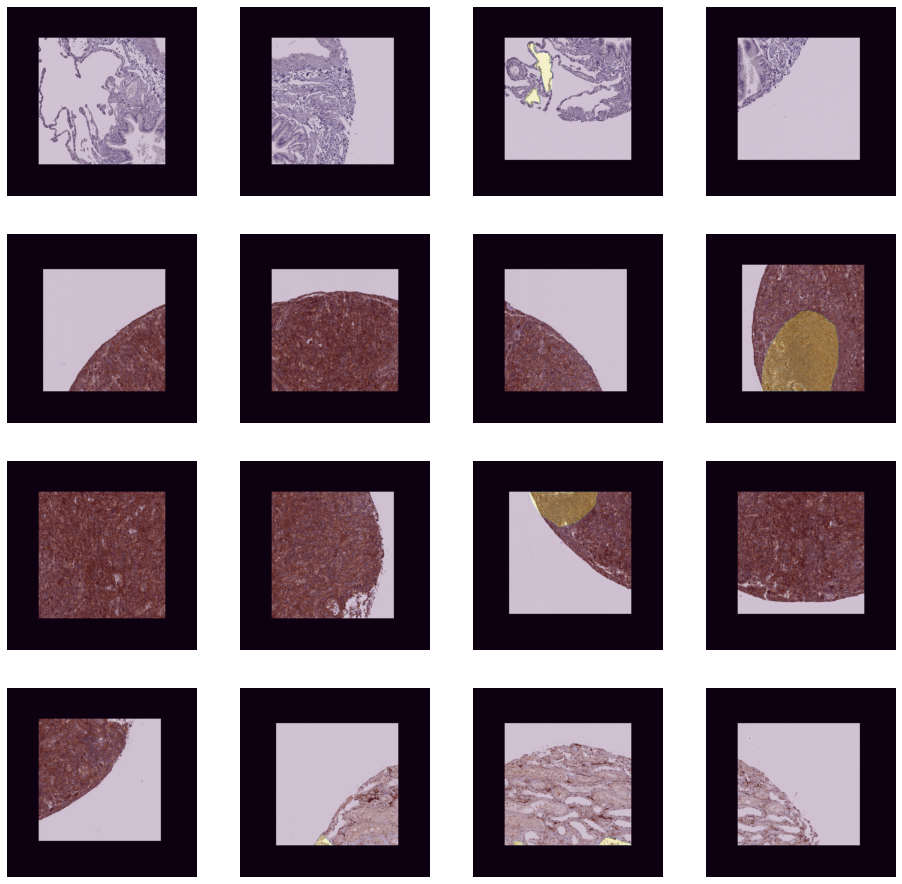

In [ ]:
columns, rows = 4,4
idx0 = 20
fig=plt.figure(figsize=(columns*4, rows*4))
with zipfile.ZipFile(OUT_TRAIN, 'r') as img_arch, \
     zipfile.ZipFile(OUT_MASKS, 'r') as msk_arch:
    fnames = sorted(img_arch.namelist())[8:]
    for i in range(rows):
        for j in range(columns):
            idx = i+j*columns
            img = cv2.imdecode(np.frombuffer(img_arch.read(fnames[idx0+idx]), 
                                             np.uint8), cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            mask = cv2.imdecode(np.frombuffer(msk_arch.read(fnames[idx0+idx]), 
                                              np.uint8), cv2.IMREAD_GRAYSCALE)
    
            fig.add_subplot(rows, columns, idx+1)
            plt.axis('off')
            plt.imshow(Image.fromarray(img))
            plt.imshow(Image.fromarray(mask), alpha=0.2)
plt.show()

In [ ]:
!mkdir /content/conv_origin_512+768_dataset_padding
!mkdir /content/conv_origin_512+768_dataset_padding/images
!mkdir /content/conv_origin_512+768_dataset_padding/masks

In [ ]:
!unzip /content/train.zip -d /content/conv_origin_512+768_dataset_padding/images
!unzip /content/masks.zip -d /content/conv_origin_512+768_dataset_padding/masks

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 extracting: /content/conv_origin_512+768_dataset_padding/images/512_16609_0004_0000.png  
 extracting: /content/conv_origin_512+768_dataset_padding/images/768_1168_0001_0000.png  
 extracting: /content/conv_origin_512+768_dataset_padding/images/768_21021_0002_0000.png  
 extracting: /content/conv_origin_512+768_dataset_padding/images/768_6730_0003_0000.png  
 extracting: /content/conv_origin_512+768_dataset_padding/images/512_8402_0005_0000.png  
 extracting: /content/conv_origin_512+768_dataset_padding/images/768_1955_0001_0000.png  
 extracting: /content/conv_origin_512+768_dataset_padding/images/512_14756_0007_0000.png  
 extracting: /content/conv_origin_512+768_dataset_padding/images/512_16149_0006_0000.png  
 extracting: /content/conv_origin_512+768_dataset_padding/images/512_18401_0004_0000.png  
 extracting: /content/conv_origin_512+768_dataset_padding/images/512_20440_0007_0000.png  
 extracting: /content/conv_origin_512+768_dataset_padding/

In [ ]:
!zip conv_origin_512+768_dataset_padding.zip -r ./conv_origin_512+768_dataset_padding

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  adding: conv_origin_512+768_dataset_padding/masks/768_2874_0002_0000.png (deflated 74%)
  adding: conv_origin_512+768_dataset_padding/masks/512_31571_0004_0000.png (deflated 94%)
  adding: conv_origin_512+768_dataset_padding/masks/512_10912_0007_0000.png (deflated 90%)
  adding: conv_origin_512+768_dataset_padding/masks/512_20955_0007_0000.png (deflated 52%)
  adding: conv_origin_512+768_dataset_padding/masks/512_8151_0008_0000.png (deflated 94%)
  adding: conv_origin_512+768_dataset_padding/masks/768_3959_0002_0000.png (deflated 49%)
  adding: conv_origin_512+768_dataset_padding/masks/512_21129_0008_0000.png (deflated 75%)
  adding: conv_origin_512+768_dataset_padding/masks/512_6611_0002_0000.png (deflated 45%)
  adding: conv_origin_512+768_dataset_padding/masks/512_22236_0006_0000.png (deflated 63%)
  adding: conv_origin_512+768_dataset_padding/masks/512_29296_0001_0000.png (deflated 55%)
  adding: conv_origin_512+768_dataset_padding/masks/512_11

In [ ]:
!mv /content/conv_origin_512+768_dataset_padding.zip /content/drive/MyDrive/data/kaggle/conv_origin_512+768_dataset_padding.zip